In [72]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import pandas as pd
import datetime as dt
import pydot
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from sklearn import tree
import sys
from graphviz import Source

mask_directory = '/Users/kathum/Research/COPEX/sink_region_files/masks'
WAM_files = '/Volumes/LaCie_10TB_Keys_KH/era5/output/backtrack/co_altclimate_nfr_2000_2023/'
sink_region_name = 'nfr'

## Open Labels and Inputs

In [73]:
# MODIFY----------
label_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/nfr_daily_precip.csv'
#input_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/nfr_daily_e_track.csv'
input_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/lagged_30_nfr_daily_e_track.csv'
local_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/figures/'
nfr_mask = xr.open_dataarray('/Users/kathum/Research/COPEX/sink_region_files/masks/co_AltClimate_Northern_Front_Range_source_region.nc')
area = xr.open_dataarray('/Users/kathum/Research/area_grids/quarter_degree_area_grid_all_lat_lon.nc')
nfr_area = (area*nfr_mask).sum(['latitude', 'longitude']).values
inches = True
climatology_y = pd.read_csv('/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/nfr_daily_climatology_precip.csv').iloc[:,1:]
#-----------------

X = pd.read_csv(input_path).iloc[:,1:] #remove first column in csv
y = pd.read_csv(label_path).iloc[29:,1:] #remove first column in csv

if inches:
    y['nfr_precip_inch'] = (y['nfr_precip_m3']/nfr_area)*39.37
    y = y.loc[:,['Date', 'nfr_precip_inch']]
    climatology_y['nfr_climatology_inch'] = (climatology_y['nfr_climatology_m3']/nfr_area)*39.37
    climatology_y = climatology_y.loc[:,['Date', 'nfr_climatology_inch']]

#split training and validation data
X_train = X.loc[(X['Date'] >= '2000-01-30') & (X['Date'] < "2018-01-01"), X.columns != 'Date']#, X.columns != 'date'] #start 30 days after bc of lag
y_train = y.loc[(y['Date'] >= '2000-01-30') & (y['Date'] < "2018-01-01"), y.columns != 'Date']#, y.columns != 'Date' ]
X_val = X.loc[(X['Date'] >= "2018-01-01") & (X['Date'] < "2022-01-01"), X.columns != 'Date']#, X.columns != 'date' ]
y_val = y.loc[(y['Date'] >= '2018-01-01') & (y['Date'] < "2022-01-01"), y.columns != 'Date']#, y.columns != 'Date' ]
X_test = X.loc[(X['Date'] >= '2022-01-01') & (X['Date'] < "2023-09-31"), X.columns != 'Date']
y_test = y.loc[(X['Date'] >= '2022-01-01') & (y['Date'] < "2023-09-31"), y.columns != 'Date']

y_clim_train = climatology_y.loc[(climatology_y['Date'] >= '2000-01-30') & (climatology_y['Date'] < "2018-01-01"), climatology_y.columns != 'Date']
y_clim_val = climatology_y.loc[(climatology_y['Date'] >= '2018-01-01') & (climatology_y['Date'] < "2022-01-01"), climatology_y.columns != 'Date']
y_clim_test = climatology_y.loc[(climatology_y['Date'] >= '2022-01-01') & (climatology_y['Date'] < "2023-09-31"), climatology_y.columns != 'Date']

y_train_dates = y.loc[(y['Date'] >= '2000-01-30') & (y['Date'] < "2018-01-01"), y.columns == 'Date']
y_val_dates = y.loc[(y['Date'] >= '2018-01-01') & (y['Date'] < "2022-01-01"), y.columns == 'Date']#, y.columns != 'Date' ]
y_test_dates = y.loc[(X['Date'] >= '2022-01-01') & (y['Date'] < "2023-09-31"), y.columns == 'Date']
# Commented lines below are to look at the split data
# print('--- TRAINING ---')
# print(X_train.iloc[[0,1,-2,-1],[0,-1]])
# print(y_train.iloc[[0,1,-2,-1],:])
# print('--- VALIDATION ---')
# print(X_val.iloc[[0,1,-2,-1],[0,-1]])
# print(y_val.iloc[[0,1,-2,-1],:])

## One Model Run

In [3]:
### MODIFY HYPERPARAMETERS WITHIN THIS CELL
fd = {
    "tree_number": 50,    # number of trees to "average" together to create a random forest
    "tree_depth": 30,      # maximum depth allowed for each tree
    "node_split": 10,     # minimum number of training samples needed to split a node
    "leaf_samples": 1,    # minimum number of training samples required to make a leaf node
    "criterion": 'friedman_mse',  # information gain metric, 'gini' or 'entropy'
    "bootstrap": True,   # whether to perform "bagging=bootstrap aggregating" or not
    "max_samples": None,  # number of samples to grab when training each tree IF bootstrap=True, otherwise None
    "random_state": 13    # set random state for reproducibility
}

### Default values are retained below for reference
# fd = {
#     "tree_number": 15,    # number of trees to "average" together to create a random forest
#     "tree_depth": 5,      # maximum depth allowed for each tree
#     "node_split": 20,     # minimum number of training samples needed to split a node
#     "leaf_samples": 1,    # minimum number of training samples required to make a leaf node
#     "criterion": 'gini',  # information gain metric, 'gini' or 'entropy'
#     "bootstrap": False,   # whether to perform "bagging=bootstrap aggregating" or not
#     "max_samples": None,  # number of samples to grab when training each tree IF bootstrap=True, otherwise None
#     "random_state": 13    # set random state for reproducibility
# }

#Produce the random forrest
forest = RandomForestRegressor(
                           n_estimators = fd["tree_number"],
                           random_state = fd["random_state"],
                           min_samples_split = fd["node_split"],
                           min_samples_leaf = fd["leaf_samples"],
                           criterion = fd["criterion"],
                           max_depth = fd["tree_depth"],
                           bootstrap = fd["bootstrap"],
                           max_samples = fd["max_samples"])

forest.fit(X_train, y_train) # Runs the forest classifier
y_pred = forest.predict(X_train)
y_pred_val = forest.predict(X_val)
y_pred_test = forest.predict(X_test)

/Users/kathum/anaconda3/envs/wamenv/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [4]:
#cacluate RMSE
from sklearn.metrics import root_mean_squared_error
print('----Training Data------')
print('Model RMSE:',f'{round(root_mean_squared_error(y_train, y_pred),4):,}', 'in')
print('Climatology RMSE:',f'{round(root_mean_squared_error(y_train,y_clim_train),4):,}', 'in')
print('No Precip RMSE:',f'{round(root_mean_squared_error(y_train,[0] * len(y_pred)),4):,}', 'in')

print('----Validation Data------')
print('Model RMSE:',f'{round(root_mean_squared_error(y_val, y_pred_val),4):,}', 'in')
print('Climatology RMSE:',f'{round(root_mean_squared_error(y_val,y_clim_val),4):,}', 'in')
print('No Precip RMSE:',f'{round(root_mean_squared_error(y_val,[0] * len(y_val)),4):,}', 'in')

print('----Testing Data------')
print('Model RMSE:',f'{round(root_mean_squared_error(y_test, y_pred_test),4):,}', 'in')
print('Climatology RMSE:',f'{round(root_mean_squared_error(y_test, y_clim_test),4):,}', 'in')
print('No Precip RMSE:',f'{round(root_mean_squared_error(y_test, [0] * len(y_pred_test)),4):,}', 'in')


----Training Data------
Model RMSE: 0.0329 in
Climatology RMSE: 0.1259 in
No Precip RMSE: 0.1397 in
----Validation Data------
Model RMSE: 0.0654 in
Climatology RMSE: 0.1166 in
No Precip RMSE: 0.1303 in
----Testing Data------
Model RMSE: 0.06 in
Climatology RMSE: 0.1189 in
No Precip RMSE: 0.1369 in


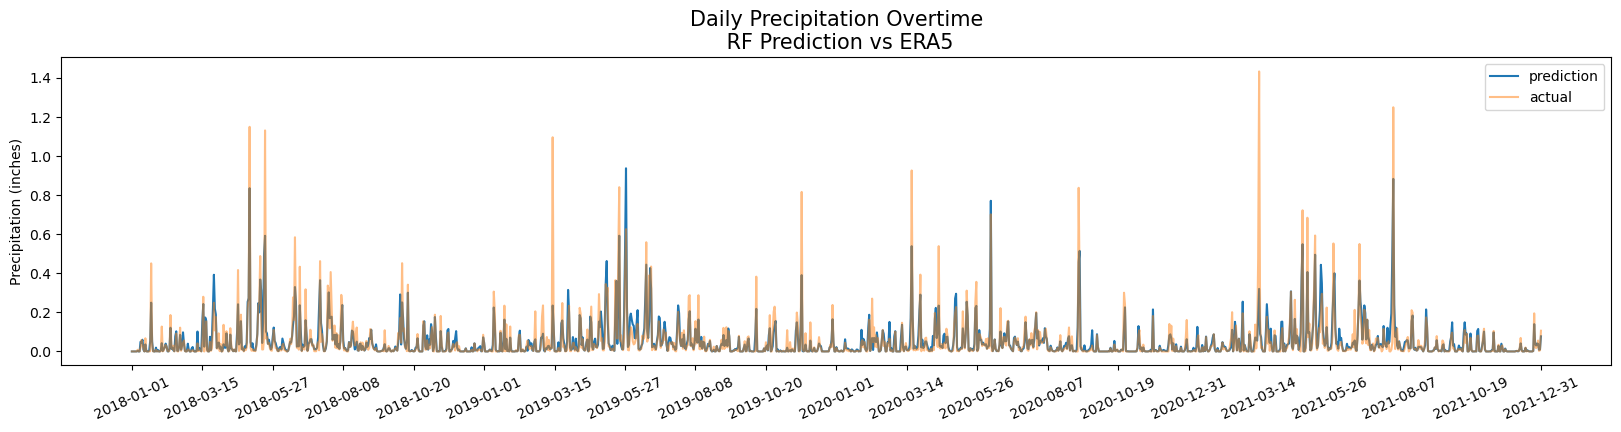

In [5]:
#evaluate +plot Validation Data
dates = y.loc[(y['Date'] >= "2018-01-01") & (y['Date'] <= "2021-12-31"), y.columns == 'Date'].values.squeeze()
fig, ax =plt.subplots(figsize=(20, 4))
plt.plot(dates,y_pred_val, label = 'prediction')
plt.plot(dates, y_val.values.squeeze(), alpha = 0.5, label = 'actual')
plt.ylabel('Precipitation (inches)')
plt.title('Daily Precipitation Overtime\n RF Prediction vs ERA5', fontdict={'fontsize':15})
plt.legend()
ax.set_xticks(ax.get_xticks()[::73])
plt.xticks(rotation = 25)

plt.savefig(local_path+'daily_precip_RF_predict_2018_2021.png', dpi = 400,bbox_inches="tight")
print('')

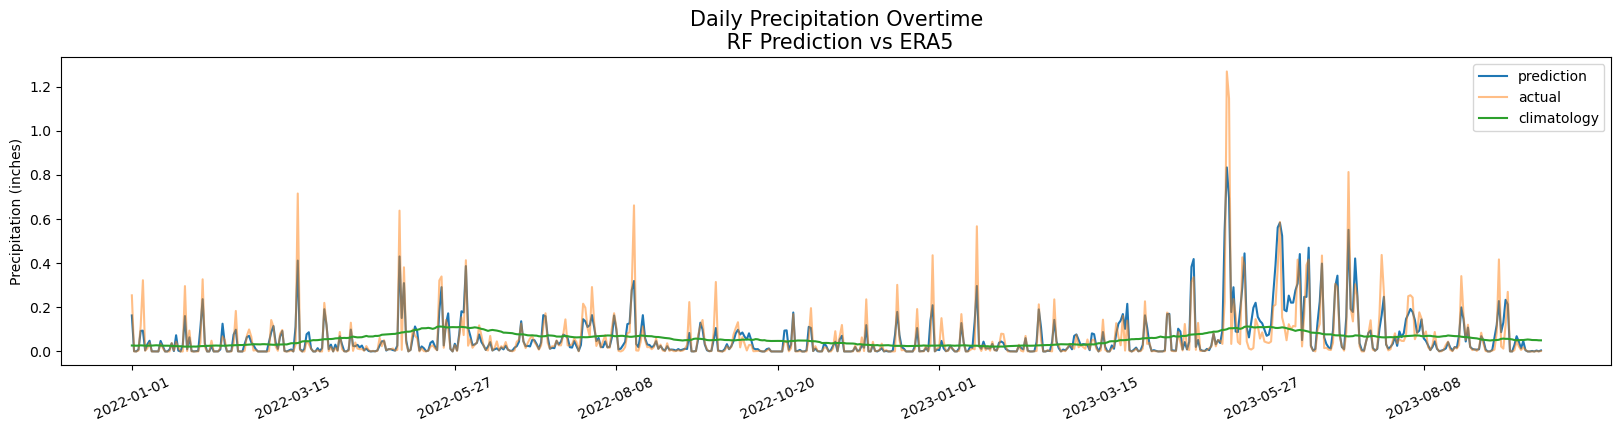

In [52]:
#evaluate +plot Validation Data
fig, ax =plt.subplots(figsize=(20, 4))
plt.plot(y_test_dates.values.squeeze(),y_pred_test, label = 'prediction')
plt.plot(y_test_dates.values.squeeze(), y_test.values.squeeze(), alpha = 0.5, label = 'actual')
plt.plot(y_test_dates.values.squeeze(),y_clim_test, label = 'climatology')

plt.ylabel('Precipitation (inches)')
plt.title('Daily Precipitation Overtime\n RF Prediction vs ERA5', fontdict={'fontsize':15})
plt.legend()
ax.set_xticks(ax.get_xticks()[::73])
plt.xticks(rotation = 25)

plt.savefig(local_path+'daily_precip_RF_predict_2022_2023.png', dpi = 400,bbox_inches="tight")
print('')

In [99]:
#timeseries of error
np.append(y_pred, np.append(y_pred_val,y_pred_test))
error = pd.DataFrame(y)
error['RF-predict'] = np.append(y_pred, np.append(y_pred_val,y_pred_test))
error['climatology'] = np.append(y_clim_train, np.append(y_clim_val,y_clim_test))
error['no_precip']=[0] * len(error)

# for column in error.columns[2:]:
#     error['abs_error_'+column] = error['nfr_precip_inch']-error[column]

perc_95 = np.percentile(error.loc[error.nfr_precip_inch>0.01]['nfr_precip_inch'].values, 50)
classes = [np.min(error['nfr_precip_inch']), 0.01, perc_95, np.max(error['nfr_precip_inch'])]
labeling = ['No Precip/Trace', 'light-moderate','heavy']
labeling = ['No Precip/Trace', 'lighter','heavier']
error['precip_class'] = pd.cut(error['nfr_precip_inch'], 
                               bins = classes, include_lowest = False, 
                               labels = labeling)
error['RF_precip_class'] = pd.cut(error['RF-predict'], 
                               bins = classes, include_lowest = False, 
                               labels = labeling)
error['clim_precip_class'] = pd.cut(error['climatology'], 
                               bins = classes, include_lowest = False, 
                               labels = labeling)

error_test = error.loc[(error['Date'] >= '2022-01-01') & (error['Date'] < "2023-09-31")]

error

Date  nfr_precip_inch  RF-predict  climatology  no_precip  \
29    2000-01-30         0.000588    0.000457     0.022002          0   
30    2000-01-31         0.000000    0.000954     0.023016          0   
31    2000-02-01        -0.000002    0.000019     0.024027          0   
32    2000-02-02         0.000000    0.000010     0.024418          0   
33    2000-02-03         0.000514    0.003832     0.025258          0   
...          ...              ...         ...          ...        ...   
8669  2023-09-26         0.000261    0.002227     0.051863          0   
8670  2023-09-27         0.000000    0.000006     0.051785          0   
8671  2023-09-28         0.001344    0.004234     0.051543          0   
8672  2023-09-29         0.000447    0.000572     0.050501          0   
8673  2023-09-30         0.001755    0.004727     0.050393          0   

         precip_class  RF_precip_class clim_precip_class  
29    No Precip/Trace  No Precip/Trace           lighter  
30    No Precip/Trace  No Precip/Trace           lighter  
31    No Precip/Trace  No Precip/Trace           lighter  
32    No Precip/Trace  No Precip/Trace           lighter  
33    No Precip/Trace  No Precip/Trace           lighter  
...               ...              ...               ...  
8669  No Precip/Trace  No Precip/Trace           heavier  
8670  No Precip/Trace  No Precip/Trace           heavier  
8671  No Precip/Trace  No Precip/Trace           heavier  
8672  No Precip/Trace  No Precip/Trace           heavier  
8673  No Precip/Trace  No Precip/Trace           heavier  

[8645 rows x 8 columns]

In [158]:
perc_95

0.047458796786992385

In [152]:
RMSE = {}
RMSE['All']= {'RF':root_mean_squared_error(error_test["nfr_precip_inch"], error_test["RF-predict"])
                     ,'Climatology':root_mean_squared_error(error_test["nfr_precip_inch"], error_test["climatology"])
                     ,'Zero_precip':root_mean_squared_error(error_test["nfr_precip_inch"], error_test["no_precip"])}

t_error = error_test.loc[error_test['nfr_precip_inch']<=0.01]
RMSE['Trace or None']= {'RF':root_mean_squared_error(t_error["nfr_precip_inch"], t_error["RF-predict"])
                     ,'Climatology':root_mean_squared_error(t_error["nfr_precip_inch"], t_error["climatology"])
                     ,'Zero_precip':root_mean_squared_error(t_error["nfr_precip_inch"], t_error["no_precip"])}

l_error = error_test.loc[(error_test['nfr_precip_inch']>0.01) & (error_test['nfr_precip_inch']<=perc_95)]
RMSE['Low']= {'RF':root_mean_squared_error(l_error["nfr_precip_inch"], l_error["RF-predict"])
                     ,'Climatology':root_mean_squared_error(l_error["nfr_precip_inch"], l_error["climatology"])
                     ,'Zero_precip':root_mean_squared_error(l_error["nfr_precip_inch"], l_error["no_precip"])}

h_error = error_test.loc[error_test['nfr_precip_inch']>perc_95]
RMSE['High']= {'RF':root_mean_squared_error(h_error["nfr_precip_inch"], h_error["RF-predict"])
                     ,'Climatology':root_mean_squared_error(h_error["nfr_precip_inch"], h_error["climatology"])
                     ,'Zero_precip':root_mean_squared_error(h_error["nfr_precip_inch"], h_error["no_precip"])}
RMSE_df = pd.DataFrame(RMSE)
print('----Trace------')
print('Model RMSE:',f'{round(RMSE["Trace or None"]["RF"],3)}', 'in')
print('Climatology RMSE:',f'{round(RMSE["Trace or None"]["Climatology"],3)}', 'in')
print('No Precip RMSE:',f'{round(RMSE["Trace or None"]["Zero_precip"],3)}', 'in\n')

print('----Lower Precip------')
print('Model RMSE:',f'{round(RMSE["Low"]["RF"],3)}', 'in')
print('Climatology RMSE:',f'{round(RMSE["Low"]["Climatology"],3)}', 'in')
print('No Precip RMSE:',f'{round(RMSE["Low"]["Zero_precip"],3)}', 'in\n')

print('----Higher Precip------')
print('Model RMSE:',f'{round(RMSE["High"]["RF"],3)}', 'in')
print('Climatology RMSE:',f'{round(RMSE["High"]["Climatology"],3)}', 'in')
print('No Precip RMSE:',f'{round(RMSE["High"]["Zero_precip"],3)}', 'in')


----Trace------
Model RMSE: 0.018 in
Climatology RMSE: 0.051 in
No Precip RMSE: 0.003 in

----Lower Precip------
Model RMSE: 0.036 in
Climatology RMSE: 0.045 in
No Precip RMSE: 0.028 in

----Higher Precip------
Model RMSE: 0.102 in
Climatology RMSE: 0.204 in
No Precip RMSE: 0.249 in


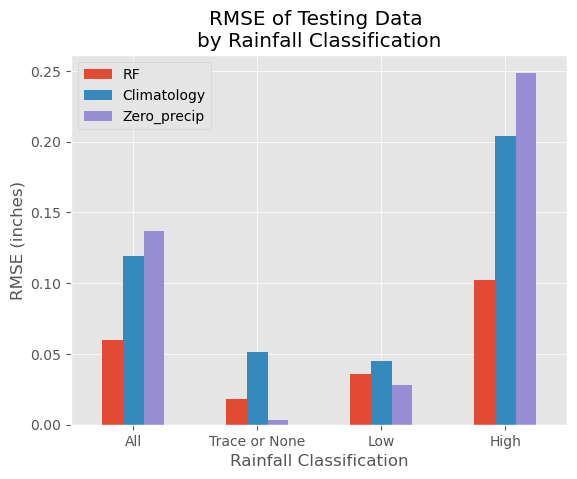

In [157]:
RMSE_df.transpose().plot(kind='bar',rot=0)
plt.style.use('ggplot')
plt.ylabel('RMSE (inches)')
plt.xlabel('Rainfall Classification')
plt.title('RMSE of Testing Data \nby Rainfall Classification')
plt.savefig(local_path+'RMSE_category_2022_2023.png', dpi = 400,bbox_inches="tight")
print('')

In [100]:
pd.crosstab(error_test.precip_class, error_test.RF_precip_class)

RF_precip_class  No Precip/Trace  lighter  heavier
precip_class                                      
No Precip/Trace              210       53        7
lighter                       11      121       44
heavier                        0       24      167

In [102]:
pd.crosstab(error_test.precip_class, error_test.clim_precip_class, dropna=False)

clim_precip_class  No Precip/Trace  lighter  heavier
precip_class                                        
NaN                              0        0        1
No Precip/Trace                  0      127      143
lighter                          0       52      124
heavier                          0       45      146

In [70]:
perc_95 = np.percentile(error.loc[error.nfr_precip_inch>0.01]['nfr_precip_inch'].values, 95)


0       trace
1       trace
2       trace
3       trace
4       trace
        ...  
8640    trace
8641    trace
8642    trace
8643    trace
8644    trace
Name: nfr_precip_inch, Length: 8645, dtype: category
Categories (3, object): ['trace' < 'rain' < 'heavy']

In [71]:
#evaluate +plot Validation Data
plot_start = error.loc[error.Date =='2022-01-01'].index.values[0]

fig, ax =plt.subplots(figsize=(20, 4))
plt.plot(error.Date.iloc[plot_start:] ,error['abs_error_RF-predict'].iloc[plot_start:], label = 'Random Forest', alpha = 0.5)
plt.plot(error.Date.iloc[plot_start:] ,error['abs_error_climatology'].iloc[plot_start:], label = 'Climatology', alpha = 0.5)
#plt.plot(error.Date,error['abs_error_no_precip'], label = 'No Precip')
plt.axhline(0, color = 'black', alpha = 0.25)

plt.ylabel('Precipitation (inches)')
plt.title('Daily Precipitation Overtime\n RF Prediction vs ERA5', fontdict={'fontsize':15})
plt.legend()
ax.set_xticks(ax.get_xticks()[::40])
plt.xticks(rotation = 25)

# plt.savefig(local_path+'daily_precip_RF_predict_2018_2021.png', dpi = 400,bbox_inches="tight")
print('')

NameError: name 'error' is not defined

In [5]:
def calc_importances(rf, feature_list):
    ''' Calculate feature importance '''
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances
    # print('')
    # [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    # print('')

    return importances

feature_names = list(X.columns)[1:]
importantces_vars = calc_importances(forest, feature_names)

perc_import = [importance*100 for importance in importantces_vars]
regions = [region[0:region.find('_')]for region in feature_names]  
days_ahead = [int(region[region.rfind('-')+1:]) for region in feature_names] 
var_name = [region[0:region.find('_')] + '_'+region[region.rfind('-')+1:] for region in feature_names]
importance_df = pd.DataFrame([[perc_import[i], regions[i], days_ahead[i], var_name[i]]for i in range(len(perc_import))], columns = ['%importance', 'region', 'lead_days', 'variable_name'])
ranked_importance = importance_df.sort_values(by='%importance', ascending=False)
ranked_importance = ranked_importance.assign(CUMSUM=ranked_importance["%importance"].cumsum()).reset_index()
ranked_importance

index  %importance          region  lead_days      variable_name  \
0       24    43.007750        Colorado          1         Colorado_1   
1       23    10.566023   Midwestern US          1    Midwestern US_1   
2       11     8.978625     Front Range          0      Front Range_0   
3       25     4.707059  Eastern Plains          1   Eastern Plains_1   
4       22     1.568425     Southern US          1      Southern US_1   
..     ...          ...             ...        ...                ...   
445    289     0.004590  Gulf of Mexico         19  Gulf of Mexico_19   
446    349     0.004229  Gulf of Mexico         23  Gulf of Mexico_23   
447    255     0.003828     Other Water         17     Other Water_17   
448    397     0.003406     Southern US         26     Southern US_26   
449    273     0.001981  Atlantic Ocean         18  Atlantic Ocean_18   

         CUMSUM  
0     43.007750  
1     53.573774  
2     62.552399  
3     67.259458  
4     68.827883  
..          ...  
445   99.986556  
446   99.990785  
447   99.994613  
448   99.998019  
449  100.000000  

[450 rows x 6 columns]

In [15]:
ranked_importance[['%importance']].iloc[20::-1].values.squeeze().sum()

79.8363741983953

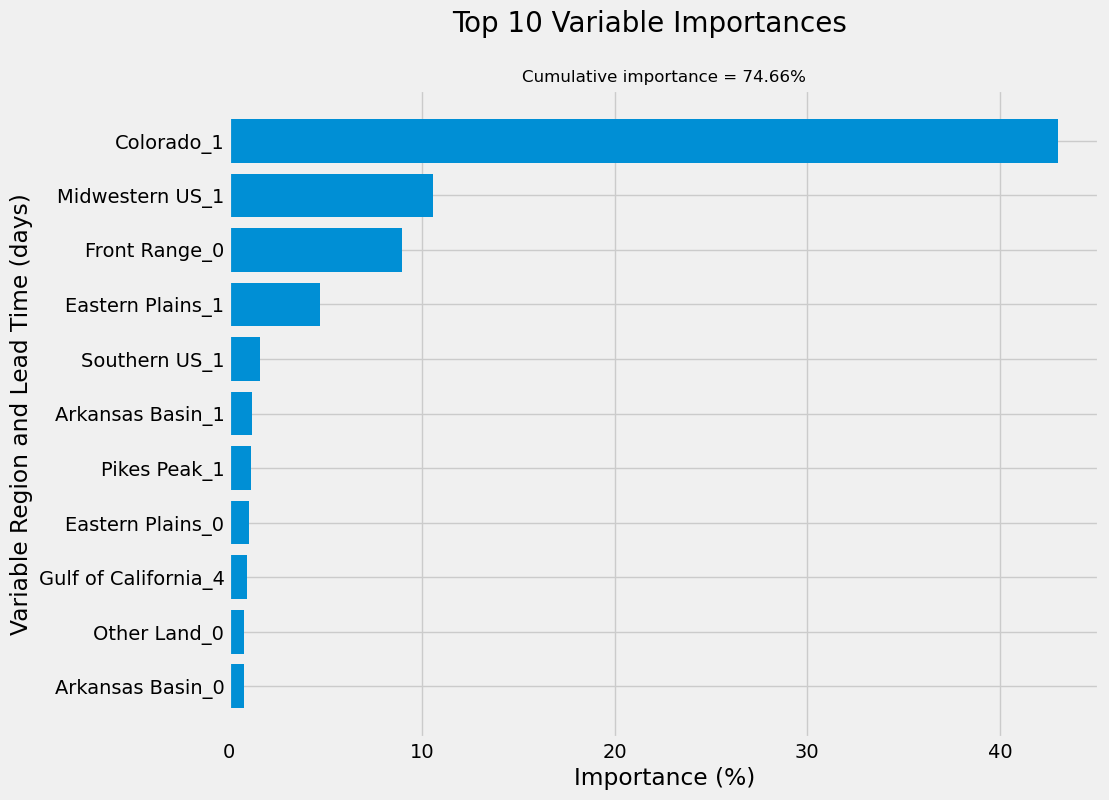

In [122]:
#plotting
importance_vals = 10
def plot_feat_importances(importances, feature_list):
    ''' Plot the feature importance calculated by calc_importances '''
    fig,ax =plt.subplots(figsize=(10,8))
    # Set the style
    plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.barh(x_values, importances)
    # Tick labels for x axis
    plt.yticks(x_values, feature_list)
    # Axis labels and title
    plt.xlabel('Importance (%)'); plt.ylabel('Variable Region and Lead Time (days)'); ax.set_title(f'Cumulative importance = {importances.sum():.2f}%', fontsize=12); fig.suptitle(f'Top {importance_vals} Variable Importances', fontsize=20)

plot_feat_importances(ranked_importance[['%importance']].iloc[importance_vals ::-1].values.squeeze(),  ranked_importance[['variable_name']].iloc[importance_vals ::-1].values.squeeze()) #HOW DO I GET THIS TO WORK

plt.savefig(local_path+f'top_{importance_vals}_variable_importance.png', dpi = 400,bbox_inches="tight")

In [56]:
print(len(np.unique(ranked_importance['region'])))
np.unique(ranked_importance['region'])


15


array(['Arkansas Basin', 'Atlantic Ocean', 'Colorado', 'Eastern Plains',
       'Front Range', 'Gulf of California', 'Gulf of Mexico',
       'High Mountain Valley', 'Midwestern US', 'Other Land',
       'Other Water', 'Pacific Ocean', 'Pikes Peak', 'Southern US',
       'Western US'], dtype=object)

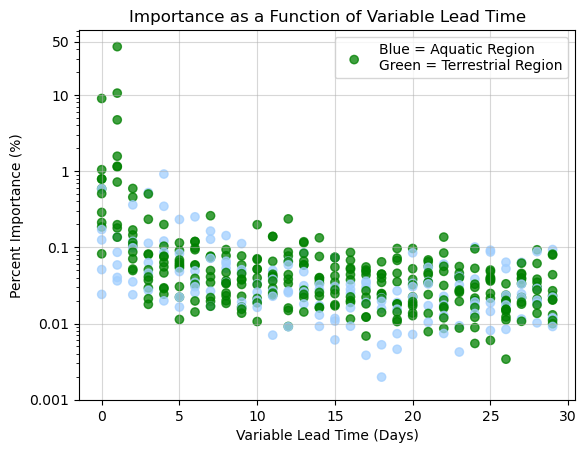

In [93]:
#'xkcd:' 
color_dict = { 'Arkansas Basin':'green', 'Eastern Plains':'green', 'High Mountain Valley':'green', 'Pikes Peak':'green',
              'Front Range':'green',
              'Colorado':'green',
              'Atlantic Ocean':'xkcd:baby blue','Gulf of Mexico':'xkcd:baby blue',
              'Gulf of California':'xkcd:baby blue', 'Pacific Ocean':'xkcd:baby blue',
              'Midwestern US':'green', 'Southern US':'green','Western US':'green',
              'Other Land':'green',
              'Other Water':'xkcd:baby blue'}

fig,ax = plt.subplots()
plt.style.use('fast')

scatter = plt.scatter(x=ranked_importance['lead_days'], y=ranked_importance['%importance'],c=[ color_dict[i] for i in ranked_importance['region'] ], alpha = 0.75, label = 'Blue = Aquatic Region\nGreen = Terrestrial Region')
plt.yscale('log')
ax.grid(alpha = 0.5)
ax.set_yticks([0.001,0.01,0.1,1,10, 50])
ax.set_yticklabels([str(val) for val in [0.001,0.01,0.1,1,10, 50]])
plt.xlabel('Variable Lead Time (Days)')
plt.ylabel('Percent Importance (%)')
plt.title('Importance as a Function of Variable Lead Time')
plt.legend()
print('')

plt.savefig(local_path+f'importans_vs_lead_time.png', dpi = 400,bbox_inches="tight")

In [85]:
scatter.legend_elements()

([], [])

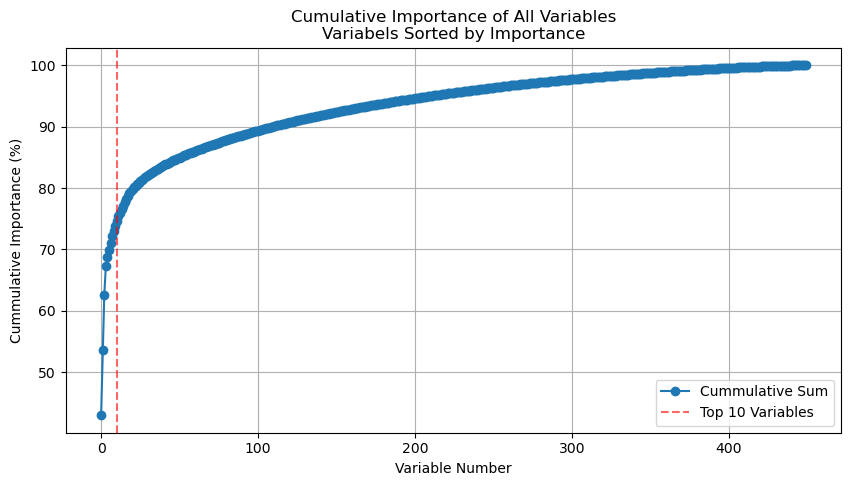

In [134]:
plt.style.use('default')
plt.style.use('fast')
fig,ax = plt.subplots(figsize= (10,5))
ranked_importance['CUMSUM'].plot(style='o-', label = 'Cummulative Sum')
plt.ylabel('Cummulative Importance (%)')
plt.xlabel('Variable Number')
ax.axvline(10, alpha = 0.6, linestyle= '--', color = 'red', label = 'Top 10 Variables')
plt.grid()
plt.title('Cumulative Importance of All Variables\nVariabels Sorted by Importance')
plt.legend()
plt.savefig(local_path+f'Cummulative_importance.png', dpi = 400,bbox_inches="tight")


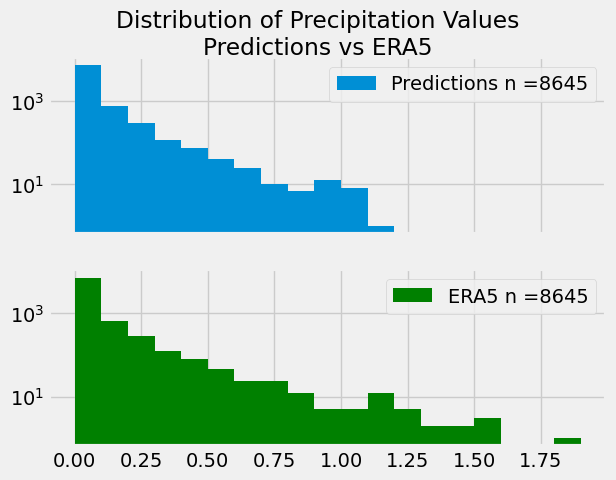

In [ ]:
all_predictions = np.append(y_pred, np.append(y_pred_val,y_pred_test))
binwidth = 0.10
bins = np.arange(0, max(y.iloc[:,1])+binwidth, binwidth)
fig, axs = plt.subplots(2, sharey=True, sharex=True)
axs[0].hist(all_predictions, bins = bins, label = f"Predictions n ={len(all_predictions)}")
axs[0].set_yscale('log')
axs[0].legend()

axs[1].hist(y.iloc[:,1], bins = bins,color = 'green', label = f"ERA5 n ={len(y.iloc[:,1])}")
axs[1].set_yscale('log')
axs[1].legend()

plt.suptitle('Distribution of Precipitation Values\nPredictions vs ERA5')


plt.savefig(local_path+'Histogram_predict_vs_era5.png', dpi = 400,bbox_inches="tight")


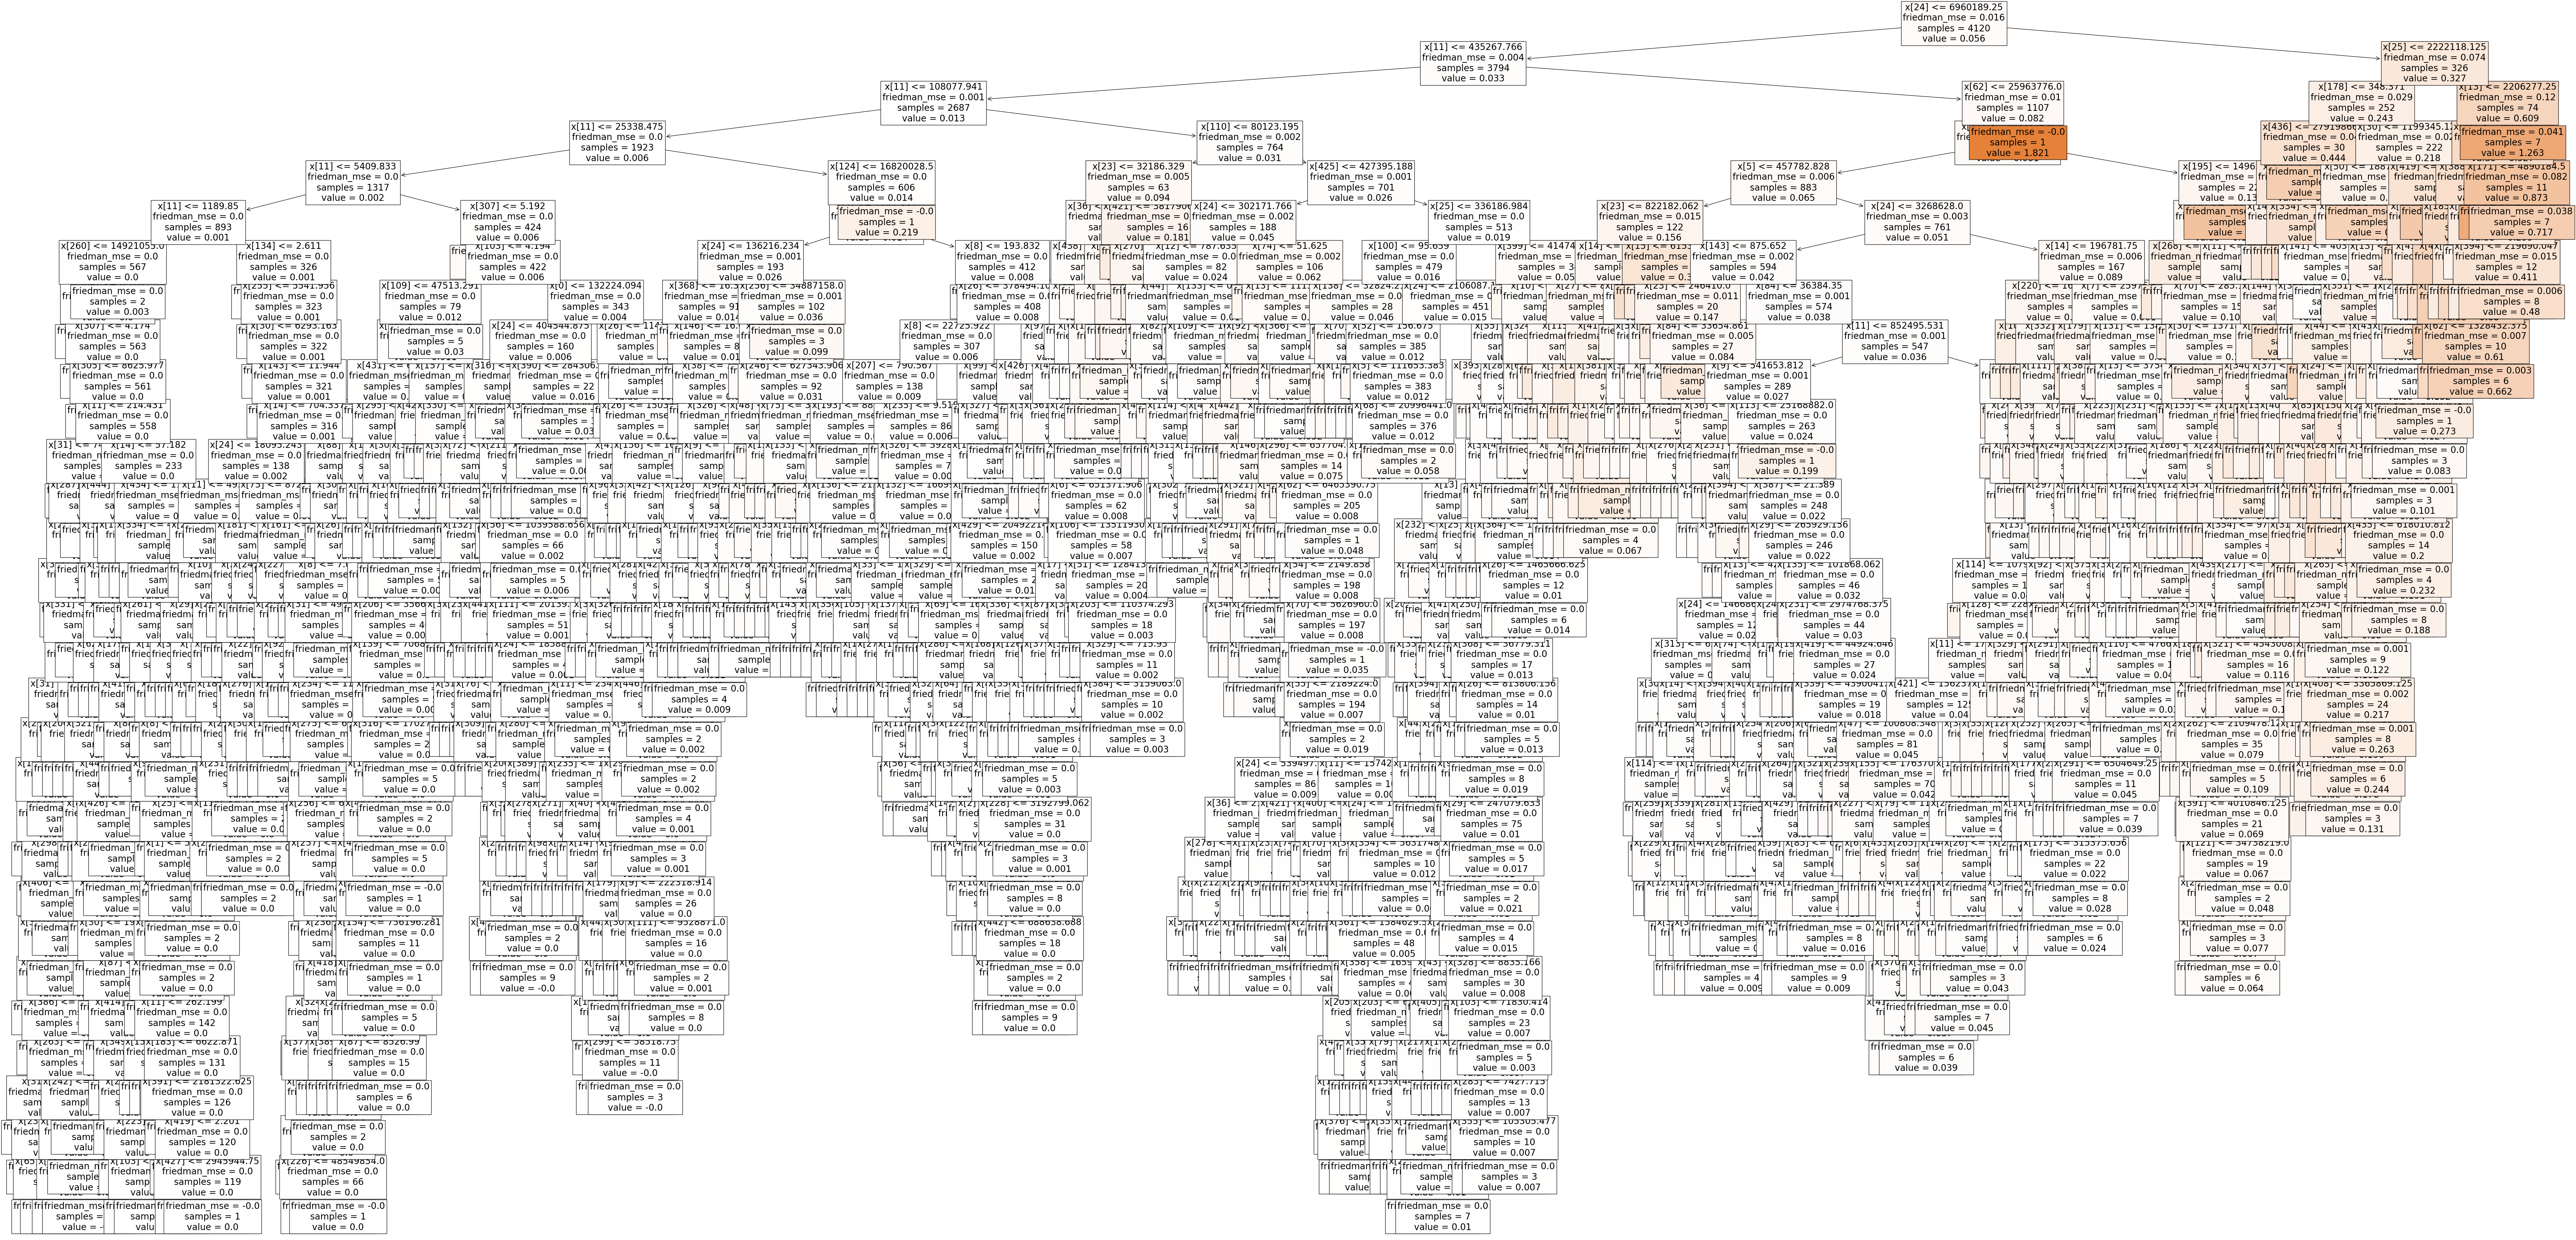

In [ ]:
plt.figure(figsize=(100,50))
tree.plot_tree(forest.estimators_[0], filled = True, fontsize=20)
print('')

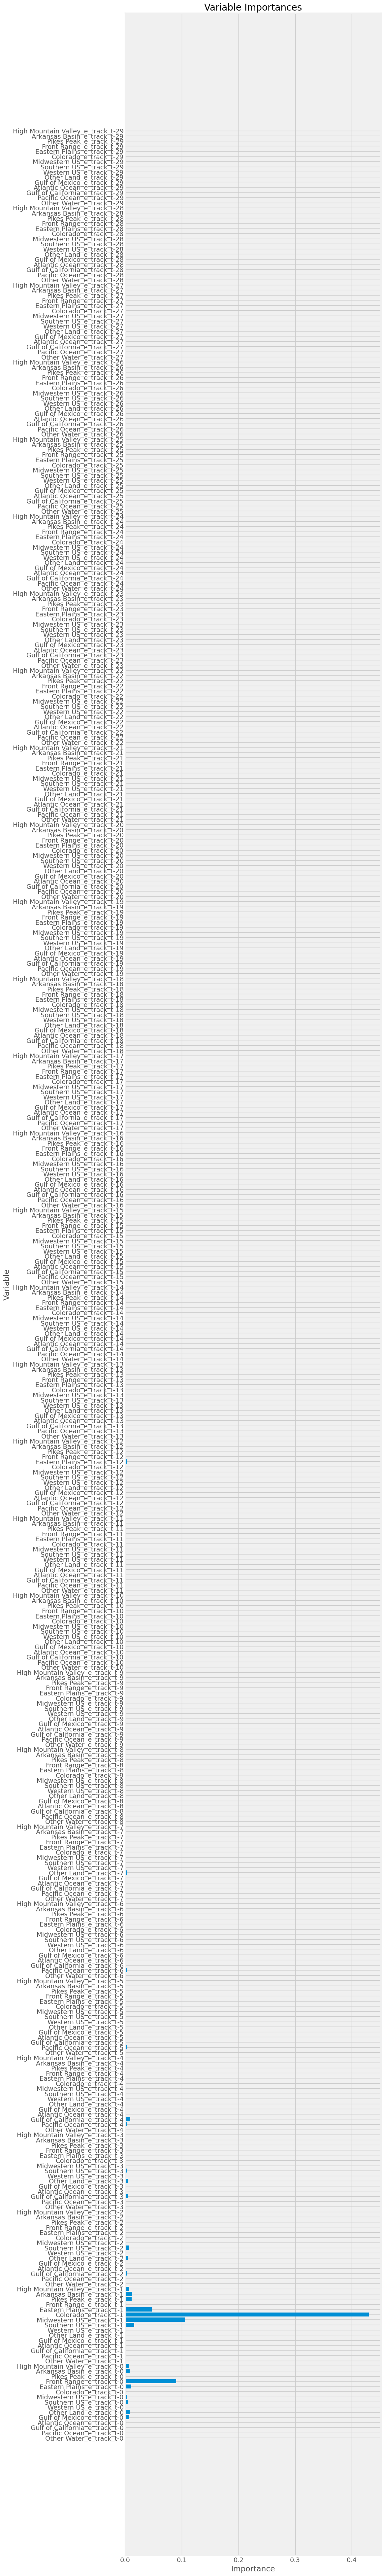

In [161]:
def calc_importances(rf, feature_list):
    ''' Calculate feature importance '''
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances
    # print('')
    # [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    # print('')

    return importances

def plot_feat_importances(importances, feature_list):
    ''' Plot the feature importance calculated by calc_importances '''
    plt.figure(figsize=(10,100))
    # Set the style
    plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.barh(x_values, importances)
    # Tick labels for x axis
    plt.yticks(x_values, feature_list)
    # Axis labels and title
    plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances')

feature_names = list(X.columns)[1:]
importantces_vars = calc_importances(forest, feature_names)
plot_feat_importances(importantces_vars,  feature_names)
plt.savefig(local_path+'variable_importances.png', dpi = 400,bbox_inches="tight")